In [3]:
# Testing for Pytorch Audio prcessing
# Andrei Cartera 
import random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torchaudio 
import torchaudio.transforms as T
import torchaudio.functional as taF 
from torchvision.transforms import ToTensor, Compose, Resize

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as nnF

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import librosa
import librosa.display
import IPython.display as ipd

from collections import defaultdict
# Install soundfile and ffmpeg-python if not already installed
# pip install soundfile
# pip install ffmpeg-python

print(torch.__version__)
print(str(torchaudio.list_audio_backends()))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define the custom order
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']


2.5.0+cu124
['soundfile']
cpu


In [4]:
def resize_spectrogram(spectrogram, target_size=(224, 224)):
  # Interpolate to the target size
  resized_spectrogram = nnF.interpolate(spectrogram.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False)
  return resized_spectrogram.squeeze(0)

In [57]:
class CustomSpeechCommandsDataset(Dataset):
  def __init__(self, base_dir: str, subset: str = None, shuffle: bool = False, out_size=(224, 224), divisor: int = 1):
    
    self.out_size=out_size    
    self.base_dir = Path(base_dir)
    self.subset = subset
    self.all_audio_paths = list(self.base_dir.glob("*/*.wav"))

    self.validation_files = self._load_list("validation_list.txt")
    self.testing_files = self._load_list("testing_list.txt")
    #if subset == "validation":
    #  self.audio_paths = [p for p in self.all_audio_paths if p in self.validation_files and p not in self.testing_files]
    #elif subset == "testing":
    #  self.audio_paths = [p for p in self.all_audio_paths if p not in self.validation_files and p in self.testing_files]
    #else:
    #  self.audio_paths = [p for p in self.all_audio_paths if p not in self.validation_files and p not in self.testing_files]
    if subset == "testing":
      self.audio_paths = [p for p in self.all_audio_paths if p not in self.validation_files and p in self.testing_files]
    else:
      self.audio_paths = [p for p in self.all_audio_paths if p not in self.testing_files]

    # Sort or shuffle the list
    if(shuffle):
      random.shuffle(self.audio_paths)
    else:
      self.audio_paths = sorted(self.audio_paths, key=lambda x: classes.index(str(x.relative_to(self.base_dir)).split('\\')[0]))

    self.label_dict = {label: idx for idx, label in enumerate(classes)} 
    #print(f"Label Dictionary: {self.label_dict}")

    # Balance the dataset 
    self.divisor = divisor
    self.balance_dataset()
    
    # (L - n_fft) / hop_size = # of hops
    # STFT
    self.spectrogram_transform = T.MelSpectrogram(
      n_fft=1024,          # Adjust size of FFT to capture more details
      hop_length=128,     # Set the hop length to control overlap
      normalized=True,
      onesided=True,
      power=1.0
    )

  def _load_list(self, filename):
    filepath = self.base_dir / filename
    with filepath.open() as fileobj:
      return {self.base_dir / line.strip() for line in fileobj}

  def __len__(self):
    return len(self.audio_paths)
  
  def __iter__(self):
    for idx in range(len(self.audio_paths)):
      yield self.__getitem__(idx)

  def __getitem__(self, idx):
    audio_path = self.audio_paths[idx]
    label = audio_path.parent.name  # Get the label as a string
    token = self.label_dict[label]  # Convert the label to an integer token
    waveform, _ = torchaudio.load(audio_path)
    waveform = self._crop(waveform)
    spectrogram = self.spectrogram_transform(waveform)
    spectrogram = resize_spectrogram(spectrogram, target_size=self.out_size)
    return spectrogram, token

  
  #def __getitem__(self, idx):
  #  audio_path = self.audio_paths[idx]
  #  label = audio_path.parent.name
  #  waveform, sample_rate = torchaudio.load(audio_path)
  #  waveform = self._crop(waveform)
  #  spectrogram = self.spectrogram_transform(waveform)
  #  spectrogram = resize_spectrogram(spectrogram, target_size=self.out_size)
  #  #spectrogram = torch.abs(torch.stft(waveform, n_fft=1024, hop_length=256,window=torch.hann_window(1024), return_complex=True))
  #  #return waveform, spectrogram, sample_rate, label, str(audio_path.relative_to(self.base_dir))
  #  return spectrogram, str(label)

  def _crop(self, waveform, target_length=16000):
    if waveform.shape[1] < target_length:
      padding = target_length - waveform.shape[1]
      waveform = nnF.pad(waveform, (0, padding))
    else:
      waveform = waveform[:, :target_length]
    return waveform
  
  
  def balance_dataset(self):
    # Count the number of samples for each label
    label_counts = defaultdict(list)
    for path in self.audio_paths:
      label = path.parent.name
      label_counts[label].append(path)

    # Find the minimum count
    min_count = min(len(paths) for paths in label_counts.values())

    # Limit each label to the nearest multiple of the divisor
    balanced_audio_paths = []
    effective_count = (min_count // self.divisor) * self.divisor
    for paths in label_counts.values():
      balanced_audio_paths.extend(paths[:effective_count])

    self.audio_paths = balanced_audio_paths
    #print(f"Balanced dataset to {effective_count} samples per label.")


In [52]:
def plot_spectrogram(spectrogram):
  spectrogram = spectrogram.cpu()  # Move to CPU if on GPU
  spectrogram = spectrogram.log2()
  
  #plt.figure(figsize=(5, 5))  # Make the figure a square
  plt.imshow(spectrogram[0, :, :].numpy(), cmap='inferno')
  #plt.axis('off')  # Remove axes
  #plt.gca().set_axis_off()
  #plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
  #plt.margins(0, 0) 
  #plt.gca().xaxis.set_major_locator(plt.NullLocator())
  #plt.gca().yaxis.set_major_locator(plt.NullLocator())
  plt.show()


In [ ]:
def save_spectrogram(spectrogram, file_path):
  spectrogram = spectrogram.cpu()  # Move to CPU if on GPU
  spectrogram = spectrogram.log2()
  
  plt.figure(figsize=(5, 5))  # Make the figure a square
  plt.imshow(spectrogram[0, :, :].numpy(), cmap='inferno')
  plt.axis('off')  # Remove axes
  plt.gca().set_axis_off()
  plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
  plt.margins(0, 0)
  plt.gca().xaxis.set_major_locator(plt.NullLocator())
  plt.gca().yaxis.set_major_locator(plt.NullLocator())
  plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
  plt.close()
  print(f"Spectrogram saved to {file_path}")

In [8]:
#input_dir = Path('../datasets/custom_speech_commands')
#output_dir = Path('./output_spectrograms')
#output_dir.mkdir(parents=True, exist_ok=True)
#dataset = CustomSpeechCommandsDataset("../datasets/custom_speech_commands",out_size=(28,28))


In [9]:
# Sample 1

#waveform, spectrogram, sample_rate, label, path = dataset[0]
#print(f"  Waveform: {waveform.shape}")
#print(f"  Label: {label}")
#print(f"  Audio Path: {path}")
#print(f"  Sample Rate: {sample_rate}")
#print(f"  Spectrogram Shape: {spectrogram.shape}, Type: {spectrogram.dtype}")


# Display sound file
#ipd.display(ipd.Audio(input_dir / path))


  # Plot the spectrogram
#plot_spectrogram(spectrogram)

# Save the spectrogram to a file
#output_file = output_dir / (str(path).split("\\")[1] + ".png")
#save_spectrogram(spectrogram, output_file)

Counter({'zero': 3300, 'one': 3300, 'two': 3300, 'three': 3300, 'four': 3300, 'five': 3300, 'six': 3300, 'seven': 3300, 'eight': 3300, 'nine': 3300})
Total Size: 33000
Sample index: 12020
Label: three
Token: 3
Spectrogram Shape: torch.Size([1, 28, 28])


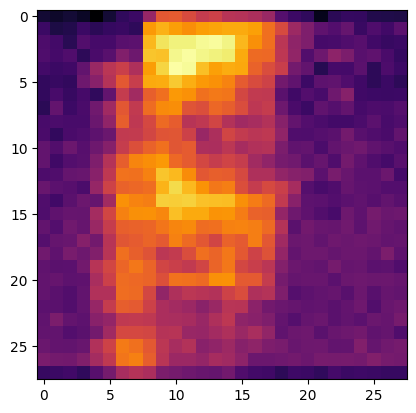

In [58]:
# Example usage

dataset = CustomSpeechCommandsDataset("../datasets/custom_speech_commands", subset="training", divisor=50, out_size=(28,28))

# Check the number of samples for each label
from collections import Counter
labels = [path.parent.name for path in dataset.audio_paths]
label_counts = Counter(labels)
print(label_counts)
print(f"Total Size: {len(dataset)}")

# Test a sample
i=12020
spectrogram, token = dataset[i]
label = classes[token]  # Retrieve the label using the token
print("Sample index: %d" %i )
print(f"Label: {label}")       
print(f"Token: {token}")       
print(f"Spectrogram Shape: {spectrogram.shape}")

# Plot the spectrogram
plot_spectrogram(spectrogram)


In [ ]:
#
#if __name__ == "__main__":
#  dataset = CustomSpeechCommandsDataset("../datasets/custom_speech_commands")
#
#
#  for i, (waveform, spectrogram, sample_rate, label, audio_path) in enumerate(dataset):
#    print(f"Sample {i}:")
#    print(f"  Waveform: {waveform}")
#    print(f"  Label: {label}")
#    print(f"  Audio Path: {audio_path}")
#    print(f"  Sample Rate: {sample_rate}")
#    
#    # Just to display first few samples
#    if i == 4:
#      break
#
